# CycleGan generate Monet Painting

This Kaggle competition to practice building and training generative deep learning models (mostly GAN). Kaggle introduces an evaluation metric called MiFID (Memorization-informed Fréchet Inception Distance) score to evaluate the quality of generated images.

DCGAN (Deep Convolutional Generative Adversarial Network) is a type of neural network architecture that is commonly used for generating images. It typically consists of two parts: a generator network that generates new images, and a discriminator network that tries to distinguish between real and generated images. CycleGAN (Cycle-Consistent Adversarial Networks) is a type of generative adversarial network (GAN) used for image-to-image translation.

The basic idea behind CycleGAN is to learn a mapping between two different image domains, such as converting images from a summer scene to a winter scene or from a horse to a zebra. This is done by training two deep neural networks simultaneously: a generator network that creates images in the target domain from input images in the source domain, and a discriminator network that tries to distinguish between real images in the target domain and generated images.

CycleGAN is unique in that it uses a cycle-consistency loss term that helps to ensure that the mapping between the two domains is consistent in both directions. This means that if you start with an image in the source domain, convert it to the target domain, and then convert it back to the source domain, you should end up with an image that is similar to the original. This helps to prevent artifacts and inconsistencies in the generated images.

## 1. Load Library

In [1]:
import tensorflow as tf
from tensorflow import keras
 
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

import os, random, json, PIL, shutil, re, imageio, glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback

## 2. Loading image data

There are two type of image, one is Monet painting image dataset, the other photo image dataset, we will use Monet dataset in discriminator.

In [2]:
data_dir = '/kaggle/input/gan-getting-started'
batch_size = 5
MONET_FILENAMES = tf.io.gfile.glob(str(data_dir + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(data_dir + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    print(image.shape)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
 

(256, 256, 3)
(256, 256, 3)


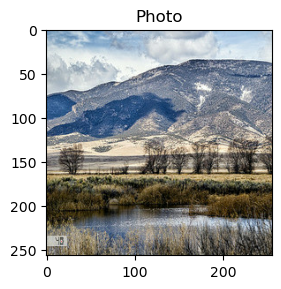

In [6]:
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

## 3.Exploratory Data Analysis/Preprocessing the image data

These image data is 256*256*3 dataset. we need check the Monet style by our eyes first.

Sample pictures from Photo and Monet

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

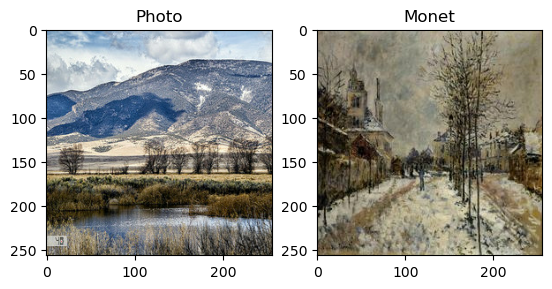

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)


Convert the image data into a dataset and show it

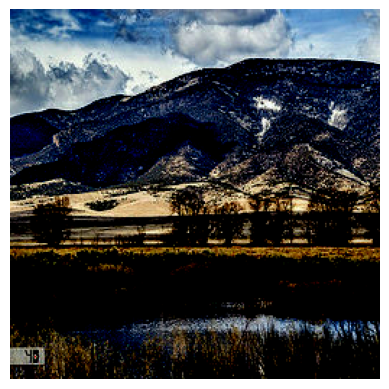

In [9]:
dataset=photo_ds
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

---------------------------------------------------------------------------

## 4. Model Architecture

Train the DCGAN model on the Monet dataset. This involves training the generator and discriminator networks using a combination of backpropagation and adversarial loss.

Here is a good example to explain generator and discriminator



 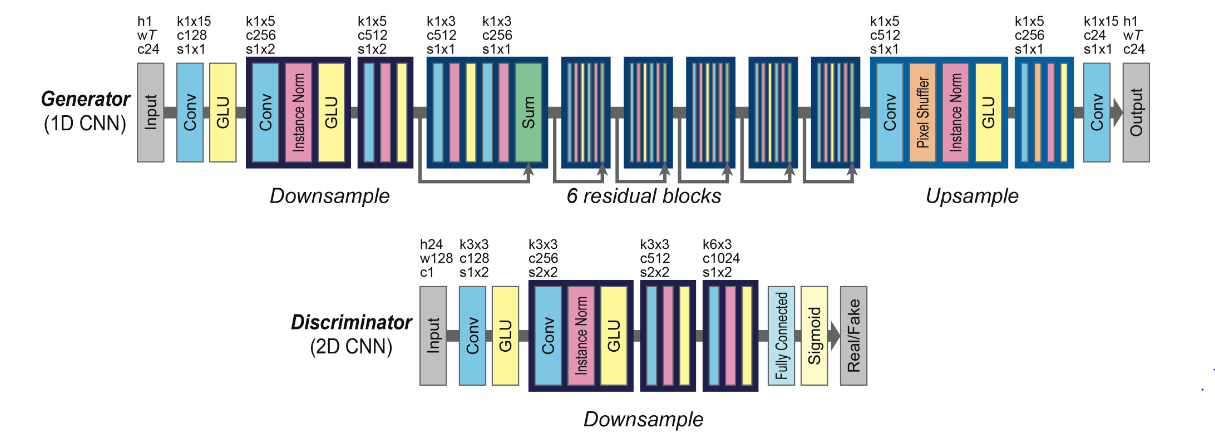

In [10]:
import tensorflow.keras.layers as L
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
    block = L.ReLU()(block)
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
    block = L.LeakyReLU()(block)
    
    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block
# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    

    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

## 4.1 Create Generator

We involved the layer which generated by encoder_block with normalization, 

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


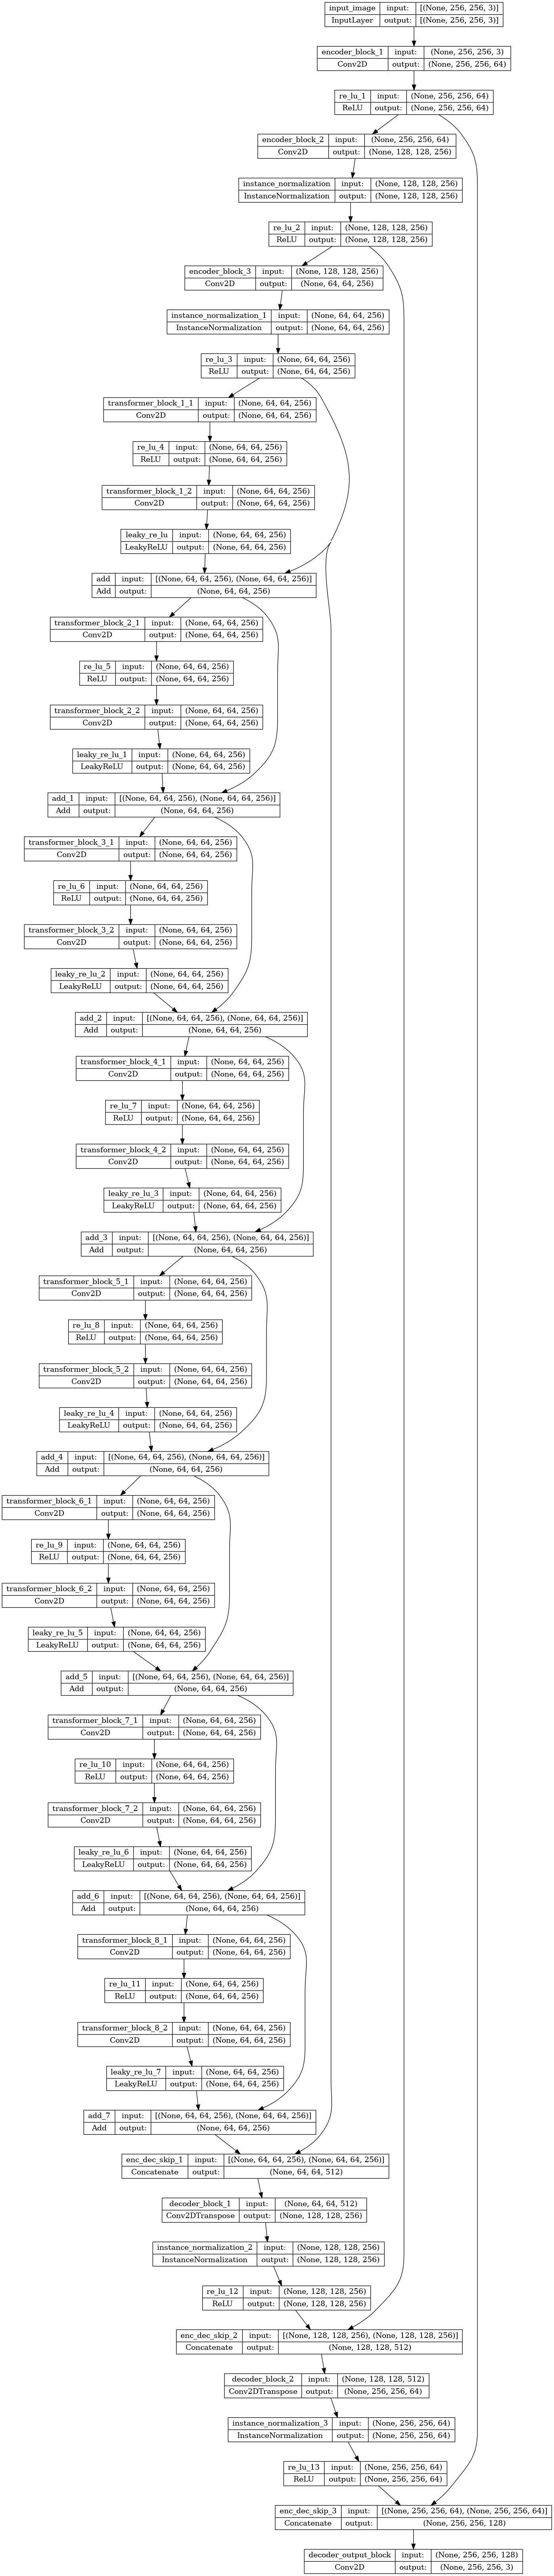

In [11]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 100
TRANSFORMER_BLOCKS = 8
GENERATOR_LR = 0.0002
DISCRIMINATOR_LR = 0.0002


def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=L.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_3')   # (bs, 64, 64, 256)
    
    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = L.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    dec_1 = decoder_block(x_skip, 256, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = L.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = Model(inputs, outputs)
    
    return generator

sample_generator = generator_fn()
# sample_generator.summary()
tf.keras.utils.plot_model(sample_generator,show_shapes=True)    

## 4.2 Create discriminator

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


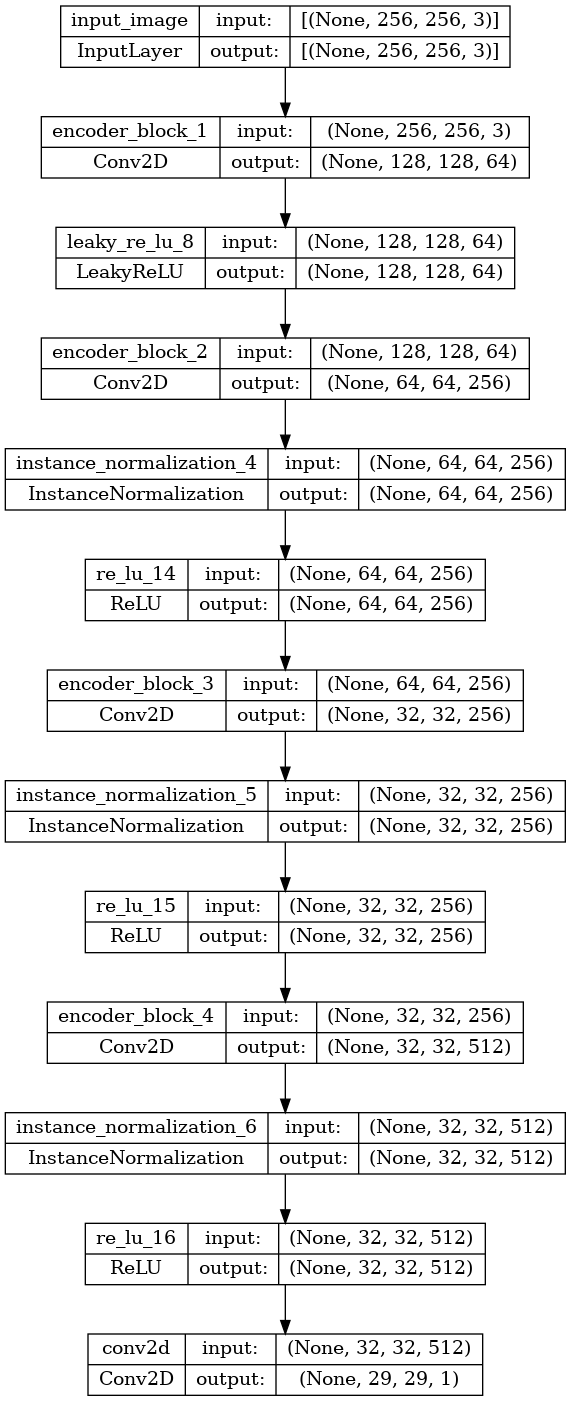

In [12]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder    
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=L.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=L.ReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=L.ReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=L.ReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)
    
    discriminator = Model(inputs, outputs)
    
    return discriminator


sample_discriminator = discriminator_fn()
# sample_discriminator.summary()
tf.keras.utils.plot_model(sample_discriminator,show_shapes=True)  

In [13]:
# Get current strategy
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.11.0


In [14]:
with strategy.scope():
    monet_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
    photo_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn(height=None, width=None) # differentiates real photos and generated photos

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


## Test the generator create a test example photo w/o GAN

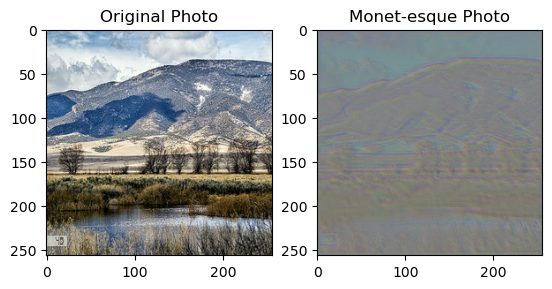

In [15]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.50 + 0.50)
plt.show()

## 4.3 Create Cycle Gan Model

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

           # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## 5. Training Model

In [17]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [18]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [19]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [20]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [21]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    

In [22]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
#     steps_per_epoch = int(max(example_monet, example_photo)//BATCH_SIZE)
    steps_per_epoch=255
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch =255  #int(max(example_monet, example_photo)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

In [23]:
with strategy.scope():
    # Create generators
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    # Create discriminators
    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)

In [24]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

## hyperparameters

I tried to adjust the epochs, used 10, the exportd images just have tiny changed, but I think 20 epochs is much more better on the picture style, so here I export the images sample by 20 epochs.

In [25]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)


Epoch 1/20
300/300 [==============================] - 235s 675ms/step - monet_gen_loss: 3.9271 - photo_gen_loss: 3.9887 - monet_disc_loss: 0.6662 - photo_disc_loss: 0.6456
Epoch 2/20
300/300 [==============================] - 207s 690ms/step - monet_gen_loss: 3.2175 - photo_gen_loss: 3.3800 - monet_disc_loss: 0.6381 - photo_disc_loss: 0.5968
Epoch 3/20
300/300 [==============================] - 207s 689ms/step - monet_gen_loss: 3.0207 - photo_gen_loss: 3.1903 - monet_disc_loss: 0.6214 - photo_disc_loss: 0.5769
Epoch 4/20
300/300 [==============================] - 207s 689ms/step - monet_gen_loss: 2.9112 - photo_gen_loss: 3.0713 - monet_disc_loss: 0.6158 - photo_disc_loss: 0.5778
Epoch 5/20
300/300 [==============================] - 206s 688ms/step - monet_gen_loss: 2.8556 - photo_gen_loss: 2.9900 - monet_disc_loss: 0.6116 - photo_disc_loss: 0.5793
Epoch 6/20
300/300 [==============================] - 206s 688ms/step - monet_gen_loss: 2.8190 - photo_gen_loss: 2.9698 - monet_disc_loss: 0

## 6. Generate sample Monet Image

In [26]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        f = plt.figure(figsize=(8, 8))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

1/1 [==============================] - 0s 331ms/step


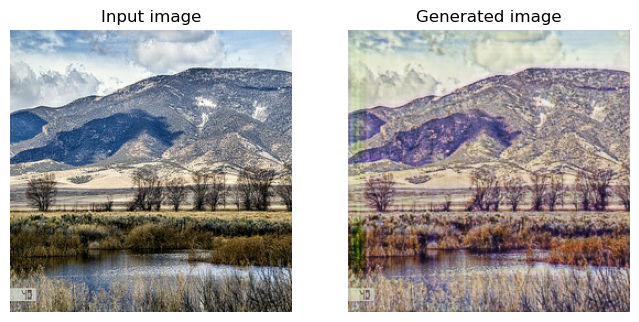

1/1 [==============================] - 0s 24ms/step


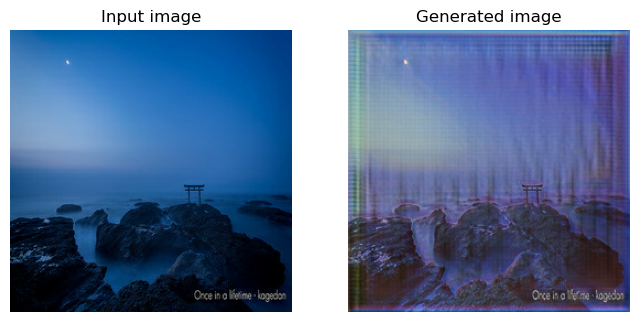

1/1 [==============================] - 0s 24ms/step


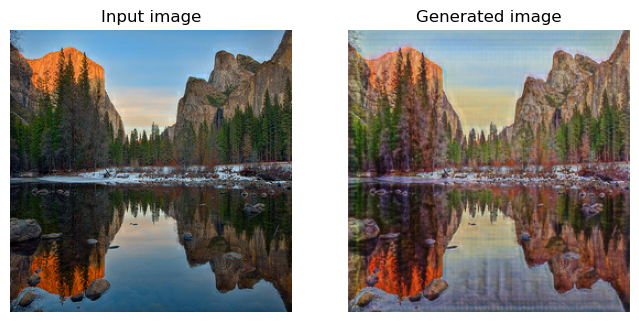

1/1 [==============================] - 0s 24ms/step


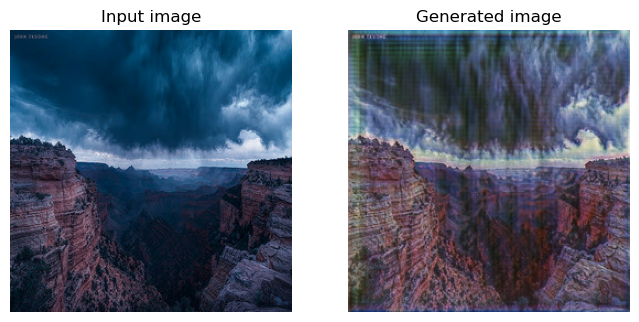

1/1 [==============================] - 0s 23ms/step


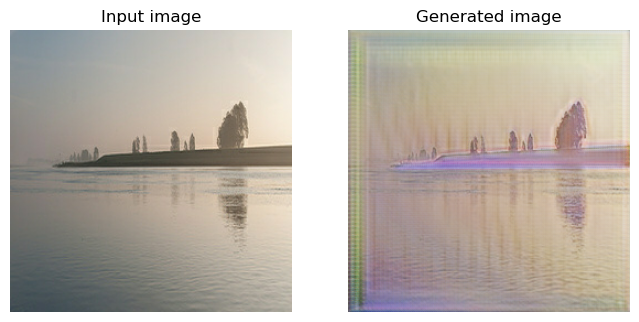

1/1 [==============================] - 0s 23ms/step


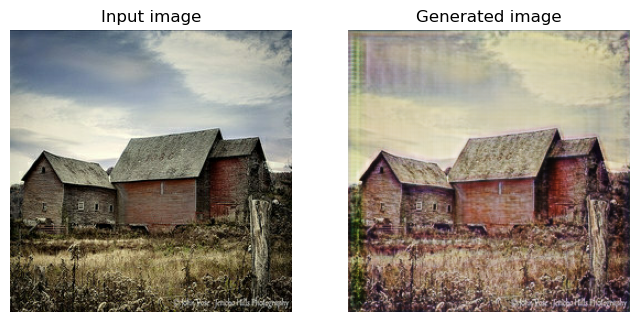

1/1 [==============================] - 0s 24ms/step


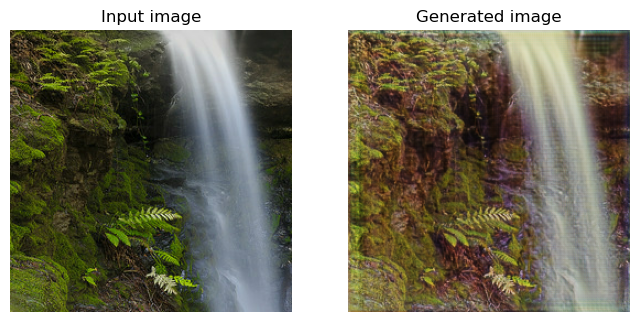

1/1 [==============================] - 0s 25ms/step


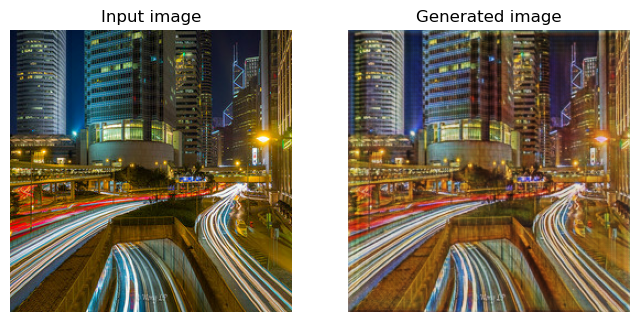

In [27]:
display_generated_samples(photo_ds.take(8), monet_generator, 8)

## 7. Generate submission zip file for images

In [28]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [29]:
path = '/kaggle/working/images/'
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path) # Create folder to save generated images
predict_and_save(photo_ds, monet_generator, '/kaggle/working/images/')

In [30]:
shutil.make_archive('/kaggle/working/images/', 'zip', '/kaggle/working/images')

print(f"Generated samples: {len([name for name in os.listdir('/kaggle/working/images/') if os.path.isfile(os.path.join('/kaggle/working/images/', name))])}")

Generated samples: 7038


## Conclusion

We can find the CycleGAN did a good job on convert photo to Monet painting, so it also means the CycleGAN is good for image transfer.

## Output Model

In [31]:
#monet_generator.save('monet_generator.h5')
#photo_generator.save('photo_generator.h5')
#monet_discriminator.save('monet_discriminator.h5')
#photo_discriminator.save('photo_discriminator.h5')